In [1]:
import numpy as np
import matplotlib.pyplot as plt

from landlab import RasterModelGrid, RadialModelGrid
from landlab.plot import imshow_grid

In [2]:
class ShallowIceAlgorithm:
    
    def __init__(self, grid):
        self.rho = 917
        self.g = 9.81
        self.A = 6.8e-24
        
        self.grid = grid
        
        if 'surface' not in self.grid.at_node.keys():
            raise ValueError('Missing input surface at RasterModelGrid nodes.')
            
    def run_one_step(self, dt, diagnostic = False):
    
        # Get surface slope at links
        self.slope = np.array(self.grid.calc_grad_at_link('surface'), dtype = np.float64)
        
        # Map thickness on to links
        self.surface_at_links = self.grid.map_value_at_max_node_to_link('surface', 'surface')
        
        # Calculate ice velocity
        self.velocity = (2/5) * self.A * (self.rho * self.g * self.slope)**3 * self.surface_at_links**4
        
        # Calculate flux at each node
        self.flux = self.velocity * self.surface_at_links
        
        # Update surface
        self.divergence = self.grid.calc_flux_div_at_node(self.flux)
        self.grid.at_node['surface'] += -self.divergence * dt
        
        # Save diagnostic values
        if diagnostic:
            self.grid.add_field('divergence', self.divergence, at = 'node')
            
            try:
                self.grid.add_field('slope', self.grid.map_mean_of_links_to_node(self.slope), at = 'node')
                self.grid.add_field('velocity', self.grid.map_mean_of_links_to_node(self.velocity), at = 'node')
                self.grid.add_field('flux', self.grid.map_mean_of_links_to_node(self.flux), at = 'node')
            except:
                pass

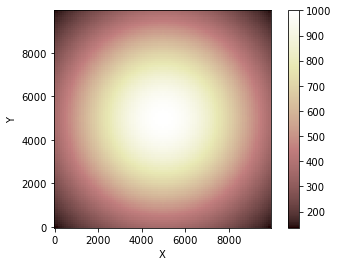

In [29]:
nx, ny = (100, 100)
dx = 100

mg = RasterModelGrid((nx, ny), dx)

scale = nx*dx
surface = 1000 * np.exp(-(((mg.node_x - scale/2) / (scale/2))**2 + ((mg.node_y - scale/2) / (scale/2))**2), dtype = np.float64)
mg.add_field('surface', surface, at = 'node')

sia = ShallowIceAlgorithm(mg)
imshow_grid(mg, 'surface')

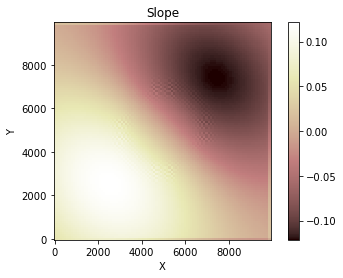

In [37]:
# sia.run_one_step(1, diagnostic = True)
imshow_grid(mg, 'slope')
plt.title('Slope')
plt.show()

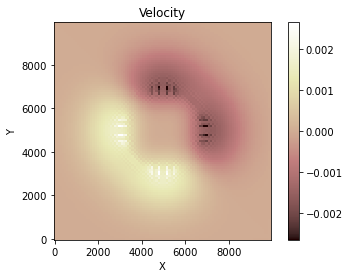

In [36]:
imshow_grid(mg, 'velocity')
plt.title('Velocity')
plt.show()

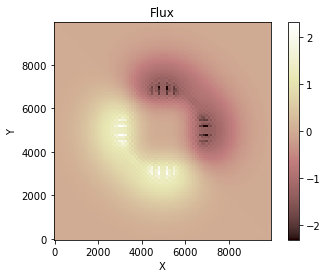

In [34]:
imshow_grid(mg, 'flux')
plt.title('Flux')
plt.show()

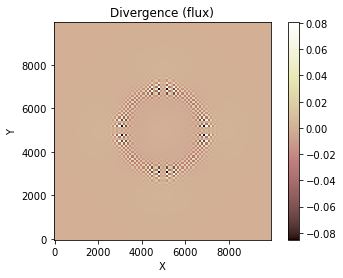

In [33]:
imshow_grid(mg, 'divergence')
plt.title('Divergence (flux)')
plt.show()

0.00963096777839


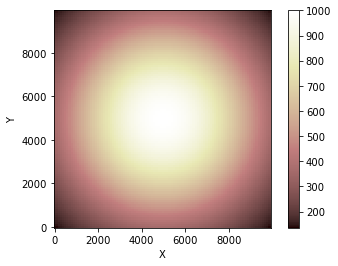

In [30]:
dt = 1
for i in range(1500):
    sia.run_one_step(dt)
imshow_grid(mg, 'surface')
print(sia.velocity.max())

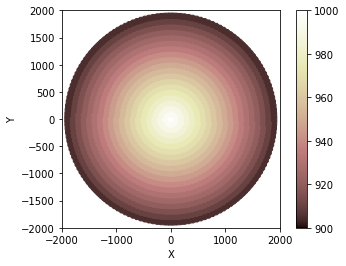

In [9]:
n_rings = 20
nodes_in_first_ring = 8
spacing = 100

mg = RadialModelGrid(n_rings, nodes_in_first_ring, spacing)

surface = 1000 - 0.05 * mg.radius_at_node
mg.add_field('surface', surface, at = 'node')

sia = ShallowIceAlgorithm(mg)
imshow_grid(mg, 'surface')

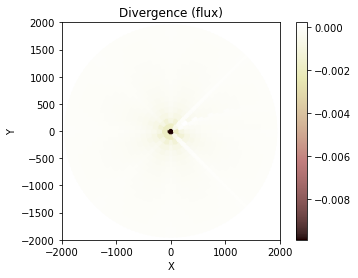

In [10]:
sia.run_one_step(1, diagnostic = True)
# print(sia.slope.max())
imshow_grid(mg, 'divergence')
plt.title('Divergence (flux)')
plt.show()